In [1]:
import this 

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Fonctions utilisées dans ce projet 

In [3]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, class_labels, explained_variance, individual_names=None):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
        individual_names (array, facultatif): Les noms des individus (ou labels). Par défaut, None.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points (en vérifiant si le nom est différent de None)
    if individual_names is not None:
        for i, name in enumerate(individual_names):
            if name is not None:
                plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True, axis='both')
    plt.show()

# Exemple d'utilisation de la fonction avec individual_names facultatif
# Vous pouvez fournir ou omettre individual_names en fonction de vos besoins.
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance)
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance, individual_names)



def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


# 1 Description du projet 
Les donnees sont des spectres proche infrarouge r ́ealis ́es sur des  ́echantillons de sol provenant de deux origines diff ́erentes. Dans le fichier « classes » qui correspond a l’origine, l’ echantillon appar- tient, soit a la classe 1 et son nom commence par « B », soit a` la classe 2 et son nom commence par
« A ».

Ce projet est un projet de comprehesion du grain 10 un projet Basique

# 2 Tracez les spectres bruts (sans pr ́etraitement). A quel type d’effet (multiplicatif, additif, d ́erive de ligne de base) est soumis ce jeu de spectres ?

In [5]:
# charger les données 
classe = pd.read_table('data/sols_classes.tabular')
spectres = pd.read_table('data/sols_spectres.tabular')

In [7]:
classe.head()

,Unnamed: 0,classe
0,B027,1
1,A092,2
2,A072,2
3,A265,2
4,A161,2


In [6]:
spectres.head()

,Unnamed: 0,1000.0,1000.4,1000.8,1001.2,1001.6,1002.0,1002.4,1002.8,1003.2,...,2477.7,2480.2,2482.6,2485.1,2487.6,2490.0,2492.5,2495.0,2497.5,2500.0
0,B027,0.408602,0.408631,0.408611,0.408649,0.408771,0.408911,0.409032,0.409144,0.409221,...,0.387619,0.386466,0.385313,0.384190,0.383149,0.382242,0.381485,0.380855,0.380309,0.379830
1,A092,0.362623,0.362626,0.362724,0.362957,0.363210,0.363283,0.363135,0.362932,0.362830,...,0.327670,0.326707,0.325750,0.324842,0.324047,0.323400,0.322895,0.322503,0.322196,0.321954
2,A072,0.452589,0.452878,0.453029,0.453063,0.453034,0.452950,0.452804,0.452665,0.452656,...,0.478239,0.477268,0.476328,0.475479,0.474777,0.474248,0.473890,0.473677,0.473565,0.473511
3,A265,0.360748,0.361001,0.361092,0.361085,0.361100,0.361173,0.361276,0.361403,0.361573,...,0.360023,0.358588,0.357159,0.355810,0.354625,0.353650,0.352876,0.352243,0.351687,0.351180
4,A161,0.351420,0.351498,0.351567,0.351633,0.351711,0.351787,0.351851,0.351947,0.352145,...,0.320827,0.319703,0.318592,0.317556,0.316656,0.315907,0.315274,0.314723,0.314247,0.313864


In [9]:
# recuperez les infos des spectres 
wavelength = spectres.drop('Unnamed: 0',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
intensities = spectres.drop('Unnamed: 0',axis=1)
intensities = intensities.values

In [10]:
# recuperez les classes
classe = classe ['classe']
classe = classe.values
# recuperez le nom des echantillons 
noms_individus = spectres['Unnamed: 0']
noms_individus = noms_individus.values

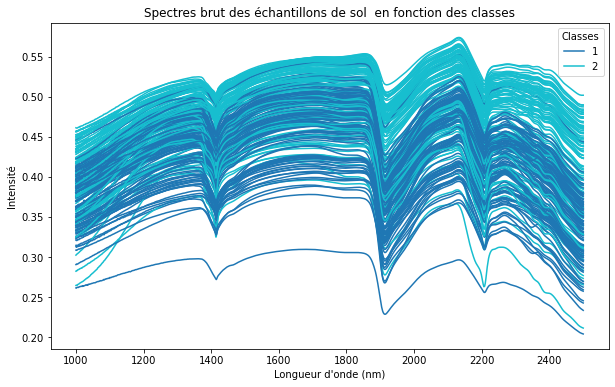

In [11]:
# Visaualisation des spectres en fonction des classes


# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(wavelength , intensities[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres brut des échantillons de sol  en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


### Observation des spectres bruts
On observe un effet additif vu que les différence observé sont constante peu importe l'intensité du signal

# 3  Realisez une ACP centr ́ee - non r ́eduite sur les spectres et dessinez la carte factorielle (des scores) des 2 premi`eres composantes, Qu’observez vous ?

In [12]:
pca = PCA( 10)
X = intensities
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[-5.67021902e-01,  1.26969967e-01, -1.81726277e-01, ...,
        -4.02583636e-03, -1.27334129e-02, -1.64854745e-03],
       [ 1.80649266e+00, -6.59406949e-02, -3.10843005e-01, ...,
         1.37352998e-02,  7.06385953e-03, -8.69188346e-03],
       [-2.66872354e+00,  6.36392283e-03, -2.10446311e-01, ...,
         9.60128507e-03,  1.34153180e-03, -6.03860303e-03],
       ...,
       [-8.93273213e-01,  7.65424998e-02, -1.78090754e-01, ...,
        -3.51481922e-03, -8.22697542e-03,  3.09108599e-03],
       [-4.62498290e-01,  3.47528945e-01,  5.34671055e-02, ...,
         8.76505477e-03, -5.06315617e-04,  2.86464809e-03],
       [ 3.81935414e-01, -1.76482142e-01, -1.32020751e-01, ...,
         3.19728041e-03, -7.20389790e-03,  4.19597836e-03]])

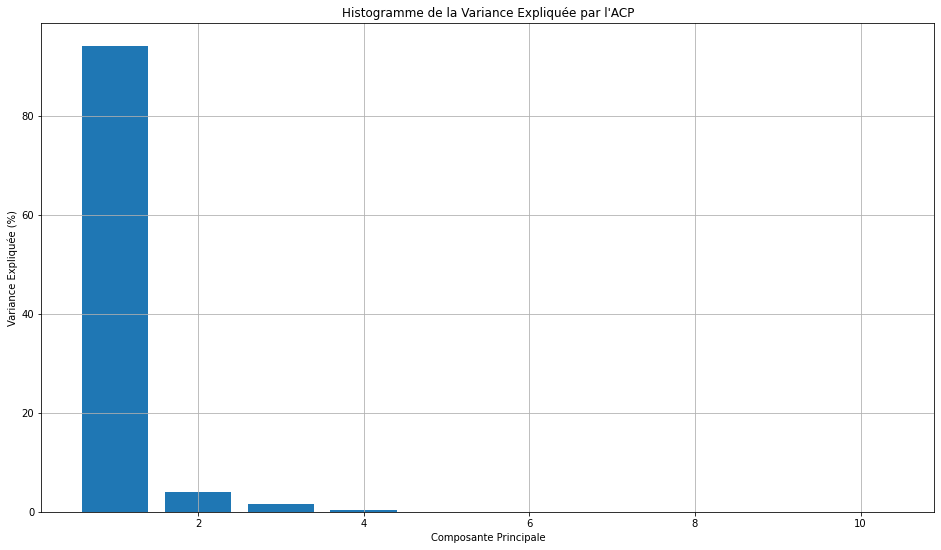

In [13]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

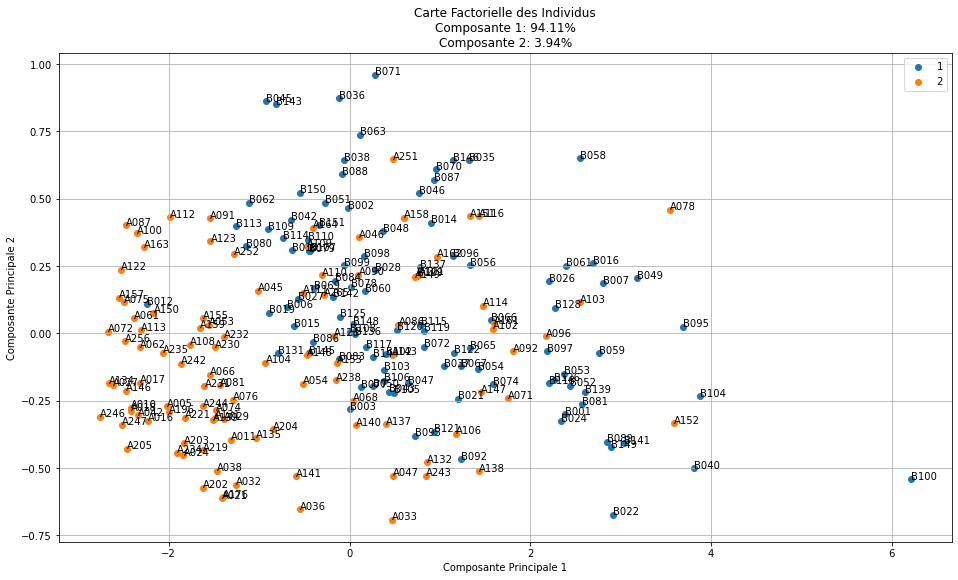

In [14]:
plot_acp_individuals(score=score, plan_indices=(0,1), class_labels=classe,individual_names=noms_individus,explained_variance=explained_variance )

### Observation ACP spectres bruts
- Histogramme de la variance expliquée par l'ACP : CP 1 explique 94 % de la variance globale du jeu (suspect pour des données spectrales )
- Carte factorielles des individus (score plot) :  on a une tendance qui se dégage suivant la CP 1 : la classe 1 a des scores positifs tandis que les individus de la classe 2 sont négatifs mais cette différence n'est pas nette 

# 4  Appliquez un pretraitement SNV sur les spectres bruts.Puis realisez une ACP sur les spectres obtenus et dessinez les scores (carte factorielle) des 2 premieres composantes. Quelles differences observez-vous par rapport a l’ACP realisee sur les spectres bruts ?

In [19]:
# Appliquer la transformation SNV à chaque spectre dans le tableau
snv_spectra = np.apply_along_axis(snv_spectrum, arr = intensities, axis =1)
len(snv_spectra)

207

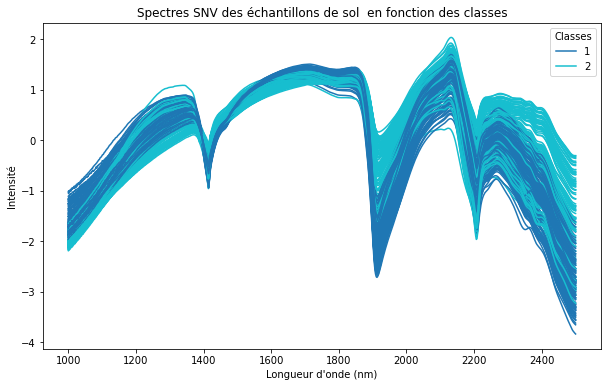

In [20]:
# Visaualisation des spectres en fonction des classes


# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(wavelength , snv_spectra[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres SNV des échantillons de sol  en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


In [22]:
pca = PCA( 10)
X = snv_spectra
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[  2.3915142 ,  -4.02723735,  -1.24361705, ...,  -0.11920203,
         -0.2516129 ,  -0.07311819],
       [ 11.11187193,   1.39418777,  -1.00587079, ...,  -0.12256202,
          0.0684827 ,   0.43763364],
       [-12.32093567,   0.18454768,  -0.14160056, ...,   0.31944993,
         -0.06784829,   0.10797508],
       ...,
       [ -1.03849343,  -2.88863346,  -1.53593773, ...,  -0.04802899,
         -0.1659855 ,  -0.23225969],
       [  7.23063144,  -1.77393973,  -0.78983431, ...,  -0.15997734,
          0.04125118,  -0.0326524 ],
       [ -3.37944283,  -3.79480963,  -1.20691469, ...,  -0.17639459,
         -0.13709779,  -0.15603717]])

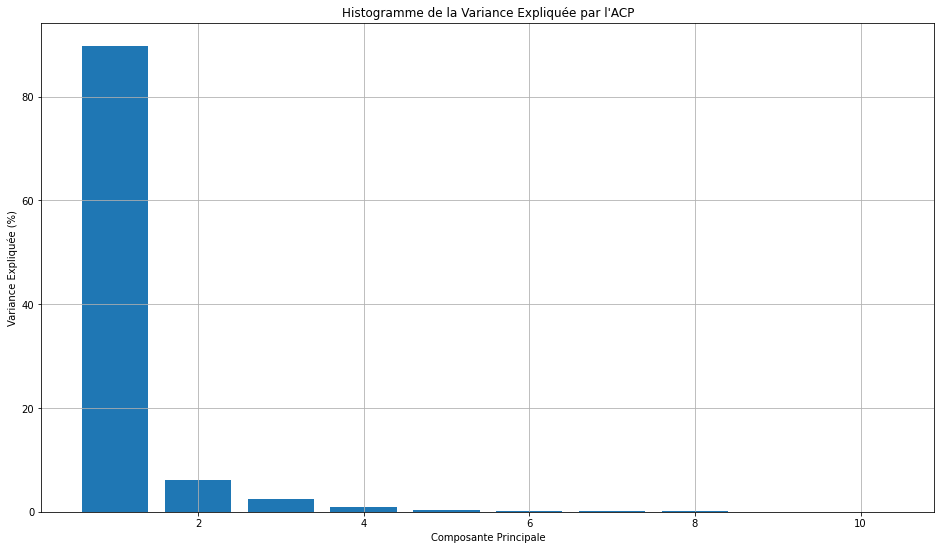

In [23]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

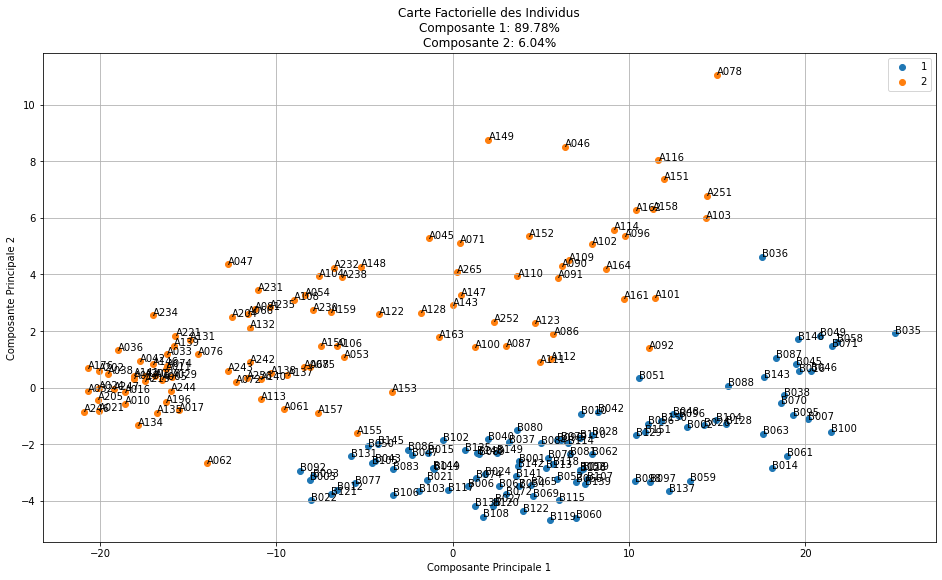

In [24]:
plot_acp_individuals(score=score, plan_indices=(0,1), class_labels=classe,individual_names=noms_individus,explained_variance=explained_variance )

### Observation ACP spectres SNV
- Histogramme de la variance expliquée par l'ACP : CP 1 explique 94 % de la variance globale du jeu (suspect pour des données spectrales )
- Carte factorielles des individus (score plot) :  
    -  on a une tendance qui se dégage suivant la CP 2 : la classe 2 a des scores positifs tandis que les individus de la classe 1 sont négatifs 
    -  La variance intraclasse est très grande normal on observe toujours l'impacte de l'éffet additif

# 5 Appliquez maintenant un pr ́etraitement Detrend d’ordre 2 sur les spectres bruts. R ́ealisez a` nouveau l’ACP et la carte factorielle. Quelles modifications obtenez-vous par rapport au pr ́etraitement SNV ?

In [27]:
### Appliquons detrend d'ordre 2
detrended_intensities = []
for y in intensities :
    coefficients = np.polyfit(wavelength,y,2) # Réalisez un ajustement de régression polynomiale d'ordre 2
    tendance_quadratique = np.polyval(coefficients,wavelength) # Supprimez la tendance quadratique des données
    detrended_data = y - tendance_quadratique
    detrended_intensities.append(detrended_data)


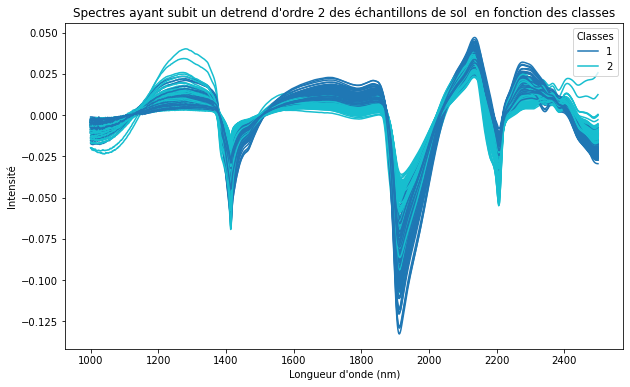

In [29]:
# Visaualisation des spectres en fonction des classes


# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(wavelength , detrended_intensities[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title("Spectres ayant subit un detrend d'ordre 2 des échantillons de sol  en fonction des classes")

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


In [30]:
pca = PCA( 10)
X = detrended_intensities
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[ 2.32743741e-02, -1.01560903e-01, -5.19099863e-03, ...,
         1.62539630e-03, -5.17290584e-03, -6.07117000e-03],
       [-1.15238843e-01, -6.01501185e-03, -8.40540327e-02, ...,
         9.90843216e-03,  9.31184179e-03, -4.14490586e-03],
       [-1.97712535e-01,  1.53131001e-02, -2.33680846e-02, ...,
        -4.62429905e-03,  7.47094374e-03, -9.53754655e-04],
       ...,
       [-3.09620871e-02, -6.59929743e-02,  1.14774031e-03, ...,
        -3.06871516e-03, -6.35053851e-03, -2.45352005e-03],
       [ 2.24090789e-01, -4.35419206e-02,  9.44229636e-03, ...,
        -2.59515980e-03, -7.78687231e-04, -6.51193123e-05],
       [-5.78735005e-02, -9.22829137e-02,  5.06984051e-03, ...,
         9.22728522e-05, -5.52117520e-03, -1.06317831e-03]])

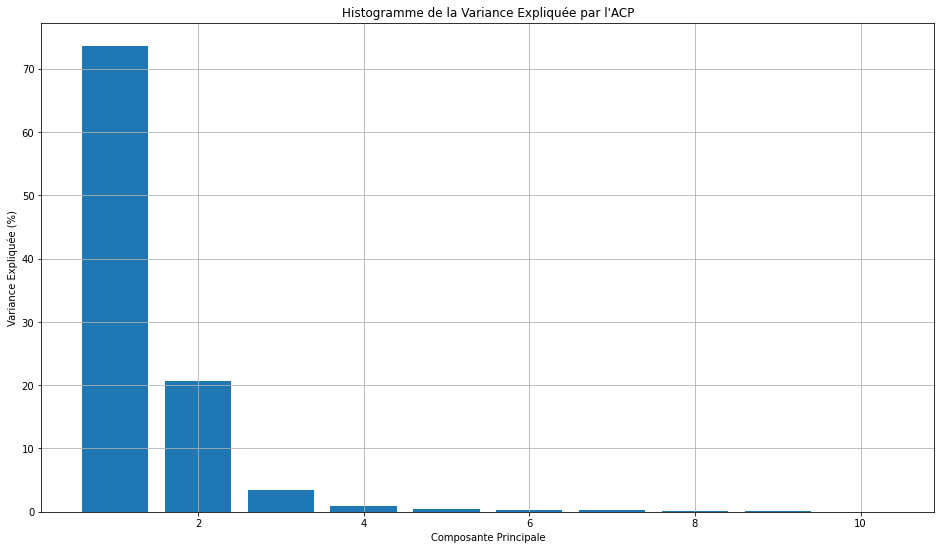

In [31]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

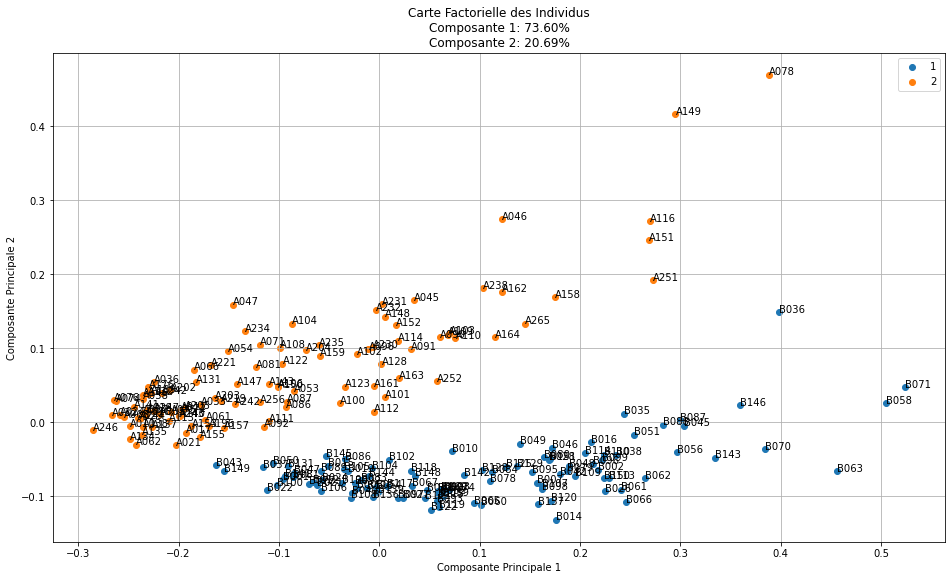

In [32]:
plot_acp_individuals(score=score, plan_indices=(0,1), class_labels=classe,individual_names=noms_individus,explained_variance=explained_variance )

### Observation ACP données detrend d'ordre 2 
- Histogramme de la variance expliquée par l'ACP : deux composantes explique plus de 95% donc interessant 
- Carte factorielles des individus (score plot) :  
    -  on a une tendance qui se dégage suivant la CP 2 : la classe 2 a des scores positifs tandis que les individus de la classe 1 sont négatifs 
    -  La variance intraclasse est très grande normal on observe toujours l'impacte de l'éffet additif
    -  Par rapport au score plot des individus SNV on peut tracer une droite qui va permettre de séparer les deux classes en deux groupes

# FIN